In [1]:
import numpy as np 
import optuna as opt 
import matplotlib.pyplot as plt

## Optimization of a Stopping Strategy

Let's consider a stock whose daily prices are given by: 
\begin{equation}
S_{n+1} = S_{n}exp(-\frac{1}{2}\sigma^2\Delta t + \sigma \sqrt{\Delta t}\epsilon_{n+1})
\end{equation}
Where $\Delta t = \frac{1}{252}$ and $(\epsilon_{n+1})_{n \geq 0}$ are i.i.d Gaussian variables

We also define : 
\begin{equation}
A_n = \frac{S_0 + S_1 + ... + S_n}{n+1}
\end{equation}

### Simulations of trajectories

In [2]:
def simul_s(S0, sigma, dt, N, nb_traj, seed = 42):
    np.random.seed(seed)
    trajectories = np.zeros((nb_traj,N+1))
    epsilon = np.random.normal(size=(nb_traj,N+1))
    trajectories[:,0] = S0
    
    for i in range(N):
        trajectories[:,i+1] = trajectories[:,i] * np.exp(-(1/2)*sigma**2 * dt + sigma* np.sqrt(dt)*epsilon[:,i])
    
    return trajectories

In [3]:
def s_to_a(trajectories):
    return np.cumsum(trajectories, axis=1) / (np.arange(1,trajectories.shape[1]+1))

(10, 23)


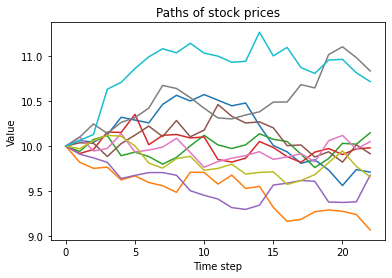

In [4]:
trajectories = simul_s(10,0.2,1/252,22,10)
print(trajectories.shape)
plt.plot(trajectories.T)
plt.title('Paths of stock prices')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.show()

(10, 23)


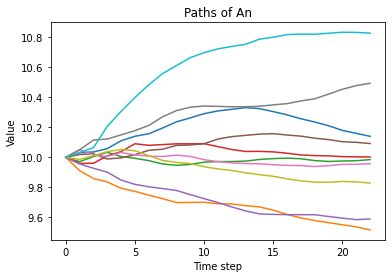

In [5]:
an = s_to_a(trajectories)
print(an.shape)
plt.title('Paths of An')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.plot(an.T)
plt.show()

In [35]:
def montecarlo(trajectories):
    a_n = s_to_a(trajectories)
    division = a_n[:,-1] / trajectories[:,-1] 
    mc_value = np.mean(division)
    confidence_interval = (mc_value - 1.96 * np.std(division) / np.sqrt(len(division)),mc_value + 1.96 * np.std(division) / np.sqrt(len(division)))
    return mc_value, confidence_interval

The value of $\mathbb{E}[\frac{A_N}{S_N}]$ should be 1.

The process given by $S_{n+1} = S_{n}exp(-\frac{1}{2}\sigma^2\Delta t + \sigma \sqrt{\Delta t}\epsilon_{n+1})$ can be seen as a Geometric Brownian Motion with a drift term $\mu = 0$. and can be rewritten as:
\begin{equation}
S_{n} = S_{0}  exp(-\frac{1}{2}\sigma^2t + \sigma W_t)
\end{equation}
Where $W_t$ is a standard Brownian Motion.


Then it can be shown that $S_n$ is a martingale and $ \mathbb{E}(S_n) = S_0 $                           $\forall n \ge 0$

We then have that $\mathbb{E}[\frac{A_N}{S_N}] - 1 = 0 \Longleftrightarrow \mathbb{E}[\frac{A_N}{S_N} - 1] = 0 \Longleftrightarrow \mathbb{E}[A_N] = \mathbb{E}[S_N] $ 

We now need to compute $\mathbb{E}[A_N]$. 

We know that $A_n = \frac{S_0 + S_1 + ... + S_n}{n+1}$. Then $\mathbb{E}[A_N] = \mathbb{E}[\frac{S_0 + S_1 + ... + S_n}{n+1}] = \frac{1}{n+1} \sum_{i=0}^{n+1} \mathbb{E}(S_i)$

The last equality shows that $\mathbb{E}[A_N] = \frac{1}{n+1}(n+1)S_0 \Longleftrightarrow \mathbb{E}[A_N] = S_0$ 


### Computation
Let's use antithetic variables to reduce the variance of the monte-carlo simulation.
If we set $\sigma = - 0.2$ we will have our antithetic trajectories

In [36]:
antithetic_trajectories = simul_s(10,-0.2,1/252,22,10)
final_trajectories = (trajectories + antithetic_trajectories) / 2

montecarlo(final_trajectories)

(1.0005664731421267, (0.999844259335695, 1.0012886869485582))

### Strategy and Optimization 

Let a $\geq$ 1 and let's consider 
\begin{equation}
\tau_a = min(min(\{ n \in \{ 0,...,N \}, A_n \geq aS_n \},N))
\end{equation}
Let's approximate $\mathbb{E}[\frac{A_{\tau_a}}{S_{\tau_a}}]$

But first, let's create a function stopping_time(a,trajectories) that will return a list of stopping times corresponding to the stopping time for each trajectory.

In [23]:
def condition(row,a):
    cond = row >= a
    #return argument of first element that satisfies the condition in each row else it returns the last argument
    return np.argmax(cond) if np.any(cond) else len(row) - 1


def stopping_time(a,trajectories):
    A = s_to_a(trajectories)
    A_divided_by_S = A / trajectories
    #We apply the above function to each trajectory of our array
    tau = np.apply_along_axis(condition,axis=1,arr=A_divided_by_S,a=a)
    return tau

In [9]:
#Test case
tau = np.array(stopping_time(1.05,trajectories))
tau
test_ratio = s_to_a(trajectories) / trajectories
S_tau_list = [traj[:t+1] for traj, t in zip(np.array(test_ratio), tau)]

### Optimization 
Now that we have the stopping time function implemented, we can create the strat_ratio strategy and find the best value with respect to a 

In [10]:
def strat_ratio(a,trajectories):
    
    test_ratio = s_to_a(trajectories) / trajectories
    tau = np.array(stopping_time(a,trajectories))
    
    #Return the value A_tau / S_tau for each trajectory and store it in a list
    S_tau_list = np.array([traj[t] for traj, t in zip(np.array(test_ratio), tau)])
    
    #return the mean to get the expected value of the ratio.
    return S_tau_list.mean()

In [26]:
strat_ratio(1.01,trajectories)

1.0127583861231715

#### Hide Optuna's verbosity

In [12]:
opt.logging.set_verbosity(opt.logging.WARNING)

### Using optuna to maximize the parameters
Instead of using the popular library scipy we will try here using the hyperparameter optimizer optuna that is popular among machine learning community and more intuitive to use.
We restrict ourselves to the interval $[1,1.1]$ as a doesn't seem to be outside it

In [44]:
def optimizer(trajectories):
    

    def objective(trial):
        a = trial.suggest_float('a', 1, 1.1)
        return strat_ratio(a,trajectories)

    study = opt.create_study(direction='maximize')
    study.optimize(objective, n_trials=1000,show_progress_bar=False)



    trial = study.best_trial
    
    print("Best trial:")
    print("Value: ", trial.value)
    print("Params: ", trial.params)

In [45]:
optimizer(trajectories)

Best trial:
Value:  1.0171316292524488
Params:  {'a': 1.0218967955825784}


Now we try the same thing but with antithetics trajectories.

In [46]:
optimizer(final_trajectories)

Best trial:
Value:  1.0006280285909657
Params:  {'a': 1.0004602746207591}
